<div style="display: flex; align-items: center; justify-content: space-between; border-bottom: 3px solid #D0D0D0; padding: 10px; font-family: Arial, sans-serif;">
  <!-- Logo -->
  <img src="https://upload.wikimedia.org/wikipedia/commons/1/1c/Uoc_masterbrand_vertical.png" alt="Logo" style="width: 150px; height: auto;">

  <!-- Detalles -->
  <div style="text-align: right; line-height: 1.6; margin-left: 20px; margin-right: 80px">
    <p style="margin: 0; font-size: 1.2em; font-weight: bold; color: #333;">Proyecto: <span style="color: #878787;">Práctica - Parte 2</span></p>
    <p style="margin: 0; font-size: 1em; font-weight: bold; color: #333;">Notebook: <span style="color: #878787;">Exploración inicial de datos de corazón</span></p>
    <p style="color: #878787;">Juan Luis González Rodríguez - Visualización de datos</span></p>
  </div>
</div>

# 0. Librerías

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 1.Exploración y limpieza de datos

Cada usuario tiene un fichero RR asociado, en el cual se recoge la información de latido a latido. Es decir, para cada segundo se registra el tiempo entre dos latidos consecutivos, el día en que se realiza el registro (1 o 2) y el momento del día en que se lleva a cabo el registro (hh:mm:ss). De esta manera, se obtiene información de la frecuencia cardíaca del usuario, para el cual, en una misma marca temporal pueden haber ocurrido diversos latidos.

Como cada usuario tiene un fichero RR.csv, se agruparán todos estos en un único dataframe con las 3 columnas que se describían anteriormente y una nueva columna con el identificador de cada usuario.

In [2]:
# Creamos un df vacio
df_RR = pd.DataFrame()

# Obtenemos la lista con los paths de los archivos
data_path = os.path.join('..', '0_data', 'MMASH')
csv_files = [os.path.join(root, file) for root, _, files in os.walk(data_path) for file in files if file.endswith('RR.csv')]

# Ordenamos por el numero de usuario, extrayendolo despues del _ del string
csv_files.sort(key=lambda x: int(''.join(filter(str.isdigit, os.path.basename(os.path.dirname(x))))))

# Iteramos sobre los archivos
for file in csv_files:
    # Leemos el archivo
    df = pd.read_csv(file, usecols=lambda column: column != 'Unnamed: 0')
    # Extraemos el identificador del usuario del nombre del fichero
    user_id = os.path.basename(os.path.dirname(file))
    # Añadimos la columna 'User' al dataframe
    df['User'] = user_id
    # Concatenamos el df al df principal
    df_RR = pd.concat([df_RR, df])

# Establecemos el usuario como la primera columna
cols = df_RR.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_RR = df_RR[cols]

# Se crea una columna datetime con el día y la hora, asumiendo que el año es 1900
df_RR['datetime'] = pd.to_datetime(df_RR['day'].astype(str) + ' ' + df_RR['time'], format='%d %H:%M:%S', errors='coerce')

# Visualizamos el df
df_RR.info()
display(df_RR.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1749295 entries, 0 to 70940
Data columns (total 5 columns):
 #   Column    Dtype         
---  ------    -----         
 0   User      object        
 1   ibi_s     float64       
 2   day       int64         
 3   time      object        
 4   datetime  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 80.1+ MB


User  ibi_s  day      time            datetime
0  user_1  0.258    1  10:10:17 1900-01-01 10:10:17
1  user_1  0.319    1  10:10:18 1900-01-01 10:10:18
2  user_1  0.266    1  10:10:18 1900-01-01 10:10:18
3  user_1  0.401    1  10:10:18 1900-01-01 10:10:18
4  user_1  1.089    1  10:10:19 1900-01-01 10:10:19

Se verifica que todos los usuarios estén presentes y tengan un número significativo de registros.

In [3]:
# Comprobamos que todos los usuarios estén presentes y tengan un número significativo de registros
df_RR['User'].value_counts(sort=False)

User
user_1      91858
user_2      71646
user_3      83965
user_4      62669
user_5      77782
user_6      92357
user_7      83507
user_8      71498
user_9      75250
user_10     68118
user_11     76803
user_12     81214
user_13     81267
user_14     78527
user_15    102340
user_16     78181
user_17     92951
user_18     74296
user_19     80239
user_20     72209
user_21     81677
user_22     70941
Name: count, dtype: int64

Todos los usuarios están presentes y tienen un número significativo de registros. A continuación se calculará la frecuencia cardíaca por minuto (BPM) en función del intervalo entre latidos (IBIs) para ello se utilizará la siguiente fórmula [1]: 

$$ \text{BPM} = \frac{60}{\text{IBI (s)}} $$

Aplicaremos esta fórmula a todos los registros de la base de datos.

In [4]:
df_RR['BPM'] = 60 / df_RR['ibi_s']

A continuación analizaremos cuál es la distribución de los valores de la variable 'BPM' para cada usuario. Esta está directamente relacionada con la variable 'ibi_s' que representa el intervalo entre latidos del corazón en segundos. Pero al ser una variable más intuitiva para el público general, la utilizaremos para el análisis.

In [5]:
# Mostramos los estadísticos descriptivos
pd.options.display.float_format = '{:.2f}'.format
df_RR['BPM'].describe()

count   1749295.00
mean         79.65
std          22.97
min           0.97
25%          65.08
50%          76.24
75%          89.42
max        1090.91
Name: BPM, dtype: float64

Se encontraron algunos valores extraños en los datos mínimos y máximos. Vamos a visualizar los datos para identificarlos de forma más sencilla.

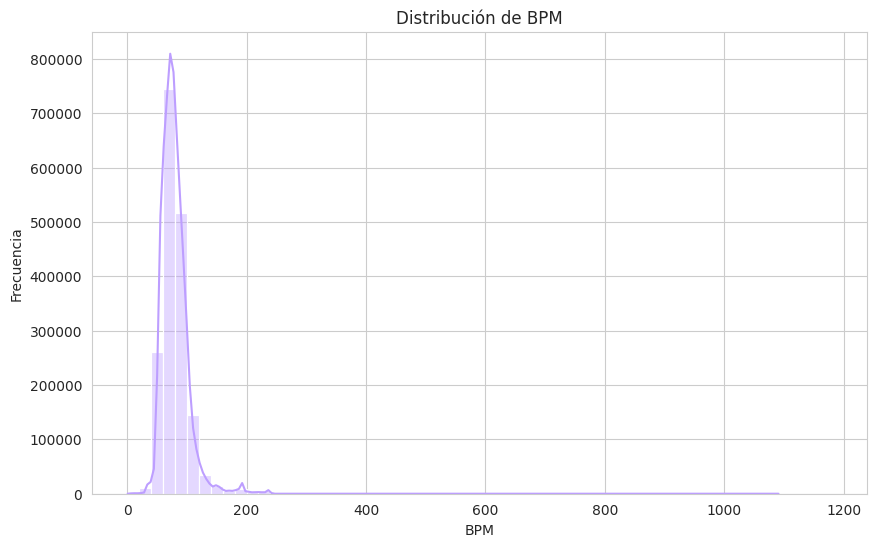

In [6]:
# Configuramos el estilo de los gráficos
sns.set_style(style='whitegrid')

# Creamos para BPM
plt.figure(figsize=(10, 6))
sns.histplot(df_RR['BPM'], bins=range(0, 1200, 20), kde=True, color='#BD9EFF', alpha=0.4)
plt.title('Distribución de BPM')
plt.xlabel('BPM')
plt.ylabel('Frecuencia')
plt.show()

Estos datos son bastante sospechosos, ya que la frecuencia cardíaca mínima es de 0.97 BPM y la máxima de 1090.91 BPM. Estos valores son claramente erróneos, ya que la frecuencia cardíaca normal puede tomar valores de entre 55 y 85 BPM en reposo [2]. Aunque se recogen datos de otros momentos del día, como puede ser instantes en los que se realiza ejercicio. Generalmente se usa la fórmula de 220 - edad para calcular la frecuencia cardíaca máxima, y aunque estos datos no sean del todo exacto, por lo que un valor de 1090.91 BPM es claramente erróneo. Por otro lado, la frecuencia cardíaca en reposo mínima de deportistas de élite puede ser de 30-40 BPM, pero no de 0.97 BPM. A continuación se visualizarán estos valores mínimos y maaximos en su serie temporal para determinar si se trata de errores puntuales o si hay un problema generalizado.

In [7]:
# Identificamos los valores atípicos, los definimos como aquellos que sean menores de 30 BPM o mayores de 220 BPM (siendo generosos y no restando la edad de la persona para considerarla como frecuencia máxima)
outliers = df_RR[(df_RR['BPM'] < 30) | (df_RR['BPM'] > 220)]
display(outliers)

print(f'Hay {outliers.shape[0]} valores atípicos en BPM')

outliers_min = outliers[outliers['BPM'] < 30]
outliers_max = outliers[outliers['BPM'] > 220]
print(f"De los cuales {outliers_min.shape[0]} valores atípicos inferiores a 30 BPM")
print(f"De los cuales {outliers_max.shape[0]} valores atípicos superiores a 220 BPM")

User  ibi_s  day      time            datetime    BPM
0       user_1   0.26    1  10:10:17 1900-01-01 10:10:17 232.56
2       user_1   0.27    1  10:10:18 1900-01-01 10:10:18 225.56
14      user_1   0.26    1  10:10:24 1900-01-01 10:10:24 234.38
17      user_1   0.25    1  10:10:25 1900-01-01 10:10:25 237.15
19      user_1   0.27    1  10:10:26 1900-01-01 10:10:26 223.88
...        ...    ...  ...       ...                 ...    ...
28391  user_22   0.27    1  18:19:49 1900-01-01 18:19:49 223.05
68062  user_22  14.50    2  07:49:42 1900-01-02 07:49:42   4.14
70934  user_22   2.53    2  08:38:46 1900-01-02 08:38:46  23.75
70935  user_22   0.27    2  08:38:47 1900-01-02 08:38:47 224.72
70938  user_22   0.26    2  08:38:48 1900-01-02 08:38:48 229.89

[5911 rows x 6 columns]

Hay 5911 valores atípicos en BPM
De los cuales 1303 valores atípicos inferiores a 30 BPM
De los cuales 4608 valores atípicos superiores a 220 BPM


Se observa que es mucho más frecuentes los outliers superiores a 220 BPM que los inferiores a 30 BPM.

Se plotean los datos en bruto de los valores de BPM de un usuario. Esto ayudará a identificar mejor cómo se producen los valores, si son picos aislados o si se producen en un rango de tiempo concreto.

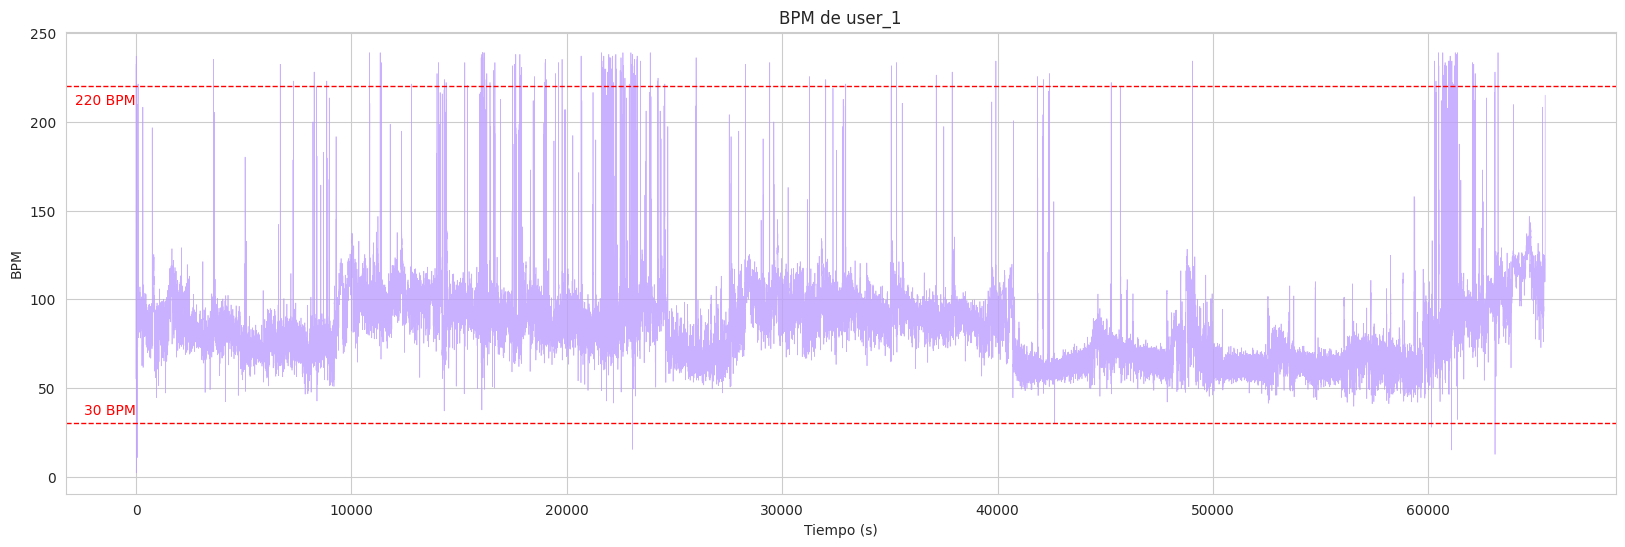

In [8]:
def plot_bpm_user(df_user, min_bpm=30, max_bpm=220):
    """
    Grafica los BPM (latidos por minuto) de un usuario a lo largo del tiempo con umbrales mínimos y máximos de BPM especificados.
    Parámetros:
    df_user (DataFrame): DataFrame que contiene los datos de BPM del usuario con las columnas 'User', 'Time' y 'BPM'.
    min_bpm (int, opcional): Umbral mínimo de BPM a resaltar en la gráfica. El valor predeterminado es 30.
    max_bpm (int, opcional): Umbral máximo de BPM a resaltar en la gráfica. El valor predeterminado es 220.
    Retorna:
    None: Esta función solo grafica los datos y no retorna ningún valor.
    """
    # Obtenemos el user
    user = df_user['User'].values[0]
    
    # Ploteamos el BPM
    sns.set_style(style='whitegrid')

    plt.figure(figsize=(20, 6))
    sns.lineplot(data=df_user, x='Time_relative', y='BPM', color='#BD9EFF', lw=0.5, alpha=0.8)
    plt.axhline(y=min_bpm, color='r', linestyle='--', lw=1)
    plt.axhline(y=max_bpm, color='r', linestyle='--', lw=1)
    plt.text(0, min_bpm+5, f'{min_bpm} BPM', color='r', fontsize=10, ha='right')
    plt.text(0, max_bpm-10, f'{max_bpm} BPM', color='r', fontsize=10, ha='right')
    plt.title(f'BPM de {user}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('BPM')
    plt.show()

def calculate_time_user(df_user):
    """
    Calcula el tiempo relativo para cada registro de un usuario.

    Parámetros:
    df_user (pandas.DataFrame): DataFrame que contiene los datos del usuario con una columna 'ibi_s'.

    Retorna:
    pandas.DataFrame: DataFrame con una columna adicional 'Time' que representa la suma acumulada de los valores de 'ibi_s'.
    """
    df_user = df_user.copy()
    df_user.loc[:, 'Time_relative'] = df_user['ibi_s'].cumsum()
    df_user.loc[:, 'Time_relative'] = df_user['Time_relative'].shift(fill_value=0)
    return df_user

# Ploteamos el user_1
df_user_1 = df_RR[df_RR['User'] == 'user_1'].copy()
df_user_1 = calculate_time_user(df_user_1)

plot_bpm_user(df_user_1)

Se puede observar que la mayoría de los picos son aislados. Encontramos estos picos (tanto hacia arriba como hacia abajo) en prácticamente todas las zonas, aunque en algunas la densidad de los picos es mayor que en otras. Para solucionar este problema se opta por la siguiente aproximación:

1. Para los valores superiores a 220 bpm e inferiores a 30 bpm se procede a imputar la media de los 10 valores anteriores y los 10 valores posteriores (sin tener en cuenta el outlier). En caso de que en esta ventana también haya otro outlier, también será descartado para realizar la media. Con esto lograremos solucionar el problema de los outliers.

2. Se aplicará una media móvil con una ventana de 60 segundos. Aunque esto reducirá la resolución, permitirá mitigar los efectos de los picos (probablemente causados por errores en la toma de datos), obteniendo información más precisa a costa de una menor resolución.

In [9]:
def outliers_cleaning(df_user, min_bpm=30, max_bpm=220, window=20):
    """
    Limpia los valores atípicos en una columna de BPM de un DataFrame de usuario.

    Parámetros:
    df_user (pd.DataFrame): DataFrame que contiene los datos del usuario con una columna 'BPM'.
    min_bpm (int, opcional): Valor mínimo de BPM considerado no atípico. Por defecto es 30.
    max_bpm (int, opcional): Valor máximo de BPM considerado no atípico. Por defecto es 220.
    window (int, opcional): Tamaño de la ventana para calcular la media de imputación. Por defecto es 20.

    Retorna:
    pd.DataFrame: DataFrame con los valores atípicos de BPM imputados por la media de la ventana.
    """


    # Se crea una copia del df del usuario
    df_user_clean = df_user.copy()

    # Se detectan los valores atípicos
    outliers = df_user_clean[(df_user_clean['BPM'] < min_bpm) | (df_user_clean['BPM'] > max_bpm)]

    # Se itera sobre los valores atípicos
    for idx, row in outliers.iterrows():

        # Se obtiene el índice de la fila
        i = df_user_clean.index.get_loc(idx)

        # Se obtiene la ventana de tiempo
        window_start = max(0, i - window // 2)

        window_end = min(df_user_clean.shape[0], i + window // 2)

        # Se imputa la media de los valores de BPM en la ventana excluyendo otros outliers
        window_data = df_user_clean.loc[window_start:window_end, 'BPM']
        window_data = window_data[(window_data >= min_bpm) & (window_data <= max_bpm)]
        df_user_clean.loc[idx, 'BPM'] = window_data.mean()

    # Se elimina la variable ibi_s ya que estos valores no se corresponden con los BPM recalculados
    df_user_clean.drop('ibi_s', axis=1, inplace=True)

    return df_user_clean

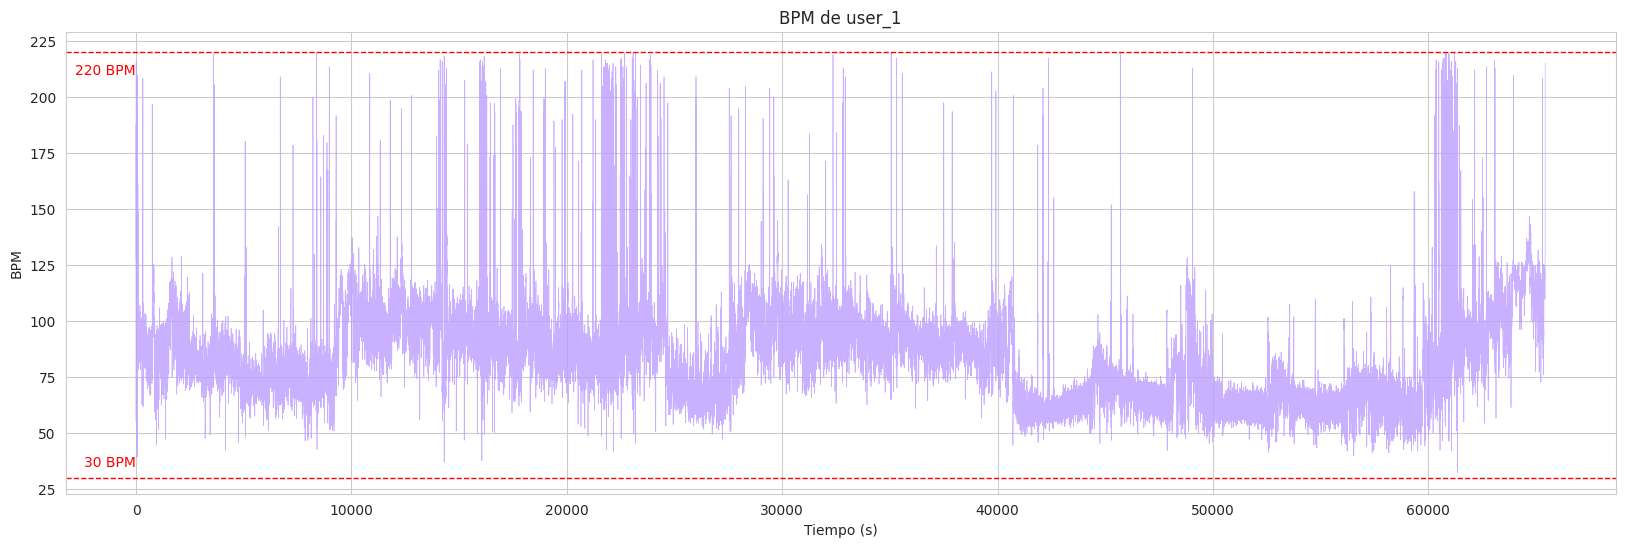

In [10]:
df_user_1_clean = outliers_cleaning(df_user_1)
plot_bpm_user(df_user_1_clean)

Se observa que se han limpiado los valores superiores a 220 BPM y los inferiores a 30 BPM. Sin embargo, la limpieza no finaliza en este punto. A continuación, se procederá a la creación de una media móvil con una resolución de 60 segundos (30 hacia atrás y 30 hacia adelante) para suavizar la señal, tal como se mencionó anteriormente.

In [11]:
def movile_mean_bpm(df_user, window_seg=60):

    # Calculamos los tiempos en los que debemos de calcular los registros, que un valor cada 60 segundos, teniendo en cuenta las horas máx y minimas
    time_min = df_user['datetime'].min()
    time_max = df_user['datetime'].max()

    # Obtenemos las marca de tiempo
    time = pd.date_range(time_min, time_max, freq=f'{window_seg}s')
    
    # Creamos un df vacio
    df_user_mean = pd.DataFrame()

    # Iteramos sobre las marcas de tiempo
    for i in range(len(time)-1):
        # Obtenemos los registros 30 segundos antes y 30 segundos después de la marca de tiempo
        # Si no hay anteriores o posteriores, se toman los más cercanos manteniendo la ventana de tiempo
        time_start = time[i]
        time_end = time[i+1]
        df_window = df_user[(df_user['datetime'] >= time_start) & (df_user['datetime'] < time_end)]

        # Calculamos la media de BPM en la ventana de tiempo
        bpm_mean = df_window['BPM'].mean()

        # Creamos el resto de columnas para añadir a df_user_mean
        user = df_user['User'].values[0]

        # Se crea un diccionario con los datos
        data = {'User': user, 'Time': time_start, 'BPM_mean': bpm_mean}

        # Se añade el diccionario al df
        df_user_mean = pd.concat([df_user_mean, pd.DataFrame([data])], ignore_index=True)

    # Puede que haya NaNs en BOM_mean debido a que no haya registros en la ventana de tiempo, en estos caso
    # se interporlan los valores (puede que haya varios NANs seguidos)
    df_user_mean['BPM_mean'] = df_user_mean['BPM_mean'].interpolate()
    df_user_mean['BPM_mean'] = round(df_user_mean['BPM_mean'], 2)
    
    return df_user_mean

In [12]:
def plot_bpm_user_based_on_time(df_user_with_time):
    # configuramos el estilo de los gráficos
    sns.set_style(style='whitegrid')

    # Ploteamos el BPM
    plt.figure(figsize=(20, 6))
    sns.lineplot(data=df_user_with_time, x='Time', y='BPM_mean', color='#BD9EFF', lw=1.5, alpha=0.8)
    plt.title(f'BPM de {df_user_with_time["User"].values[0]}')
    plt.xlabel('Tiempo')
    plt.ylabel('BPM')

    # Configuramos los ticks del eje x
    x_ticks = pd.date_range(start=df_user_with_time['Time'].min().replace(minute=0, second=0), end=df_user_with_time['Time'].max(), freq='1h')
    plt.xticks(x_ticks, [tick.strftime('%d %H:%M') for tick in x_ticks], rotation=90)

    plt.ylim(30, 220)
    plt.yticks(range(30, 220, 30))
    plt.show()

In [13]:
df_user_1_mean = movile_mean_bpm(df_user_1_clean)
display(df_user_1_mean.head())
print(f"Hay {df_user_1_mean.shape[0]} registros tras el cálculo de la media móvil con una ventana de 60 segundos")

User                Time  BPM_mean
0  user_1 1900-01-01 10:10:17    139.34
1  user_1 1900-01-01 10:11:17    119.18
2  user_1 1900-01-01 10:12:17    100.70
3  user_1 1900-01-01 10:13:17     88.87
4  user_1 1900-01-01 10:14:17     92.12

Hay 1415 registros tras el cálculo de la media móvil con una ventana de 60 segundos


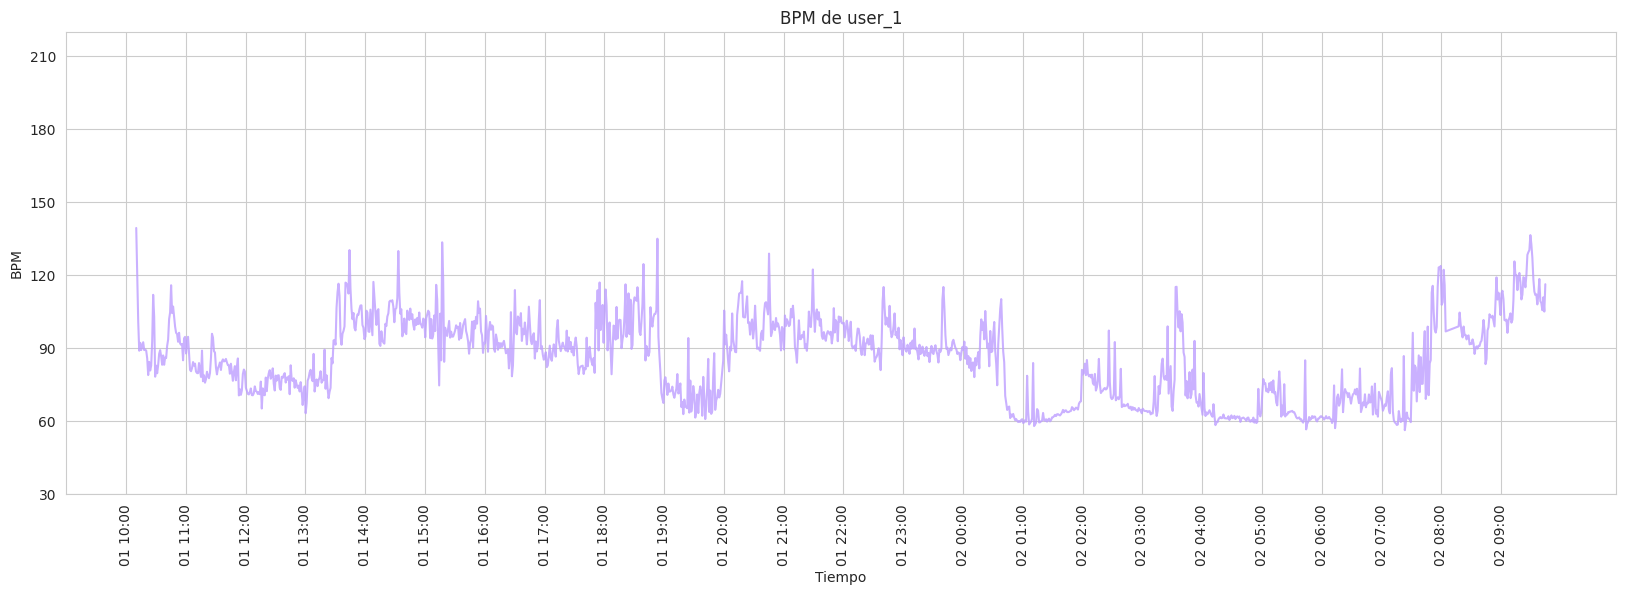

In [14]:
plot_bpm_user_based_on_time(df_user_1_mean)

Después de aplicar la media móvil, se obtuvieron 1415 registros para el usuario 1. Estos datos son más manejables y representan mejor la frecuencia cardíaca del usuario. Una vez mostrado el procedimiento de limpieza y cálculo de la media móvil para un usuario, se procederá a realizar el mismo procedimiento para todos los usuarios y a visualizarlos para detectar posibles patrones de errores en los datos.

In [15]:
def cleaning_process(df_user):
    """
    Realiza el proceso de limpieza de los datos de un usuario.

    Parámetros:
    df_user (pd.DataFrame): DataFrame que contiene los datos del usuario con las columnas 'User', 'Time' y 'BPM'.

    Retorna:
    pd.DataFrame: DataFrame con los valores atípicos de BPM imputados por la media de la ventana y la media móvil de 60 segundos.
    """
    # Se calcula el tiempo relativo
    df_user = calculate_time_user(df_user)

    # Se limpian los valores atípicos
    df_user = outliers_cleaning(df_user)

    # Se calcula la media móvil
    df_user = movile_mean_bpm(df_user)

    return df_user

In [16]:
df_RR_clean = pd.DataFrame()

for user in tqdm(df_RR['User'].unique(), desc="Processing users"):
    df_user = df_RR[df_RR['User'] == user].copy()
    df_user_clean = cleaning_process(df_user)
    df_RR_clean = pd.concat([df_RR_clean, df_user_clean])

# Resetamos el índice
df_RR_clean.reset_index(drop=True, inplace=True)

Processing users: 100%|██████████| 22/22 [01:18<00:00,  3.58s/it]


Una vez procesados los usuarios, se procede a plotear sus datos originales y limpios. Como la resolución de los datos originales es mucho mayor y encontramos hasta varios registros en un mismo segundo, para los datos originales se mostrará la media de los valores de BPM para cada instante temporal.

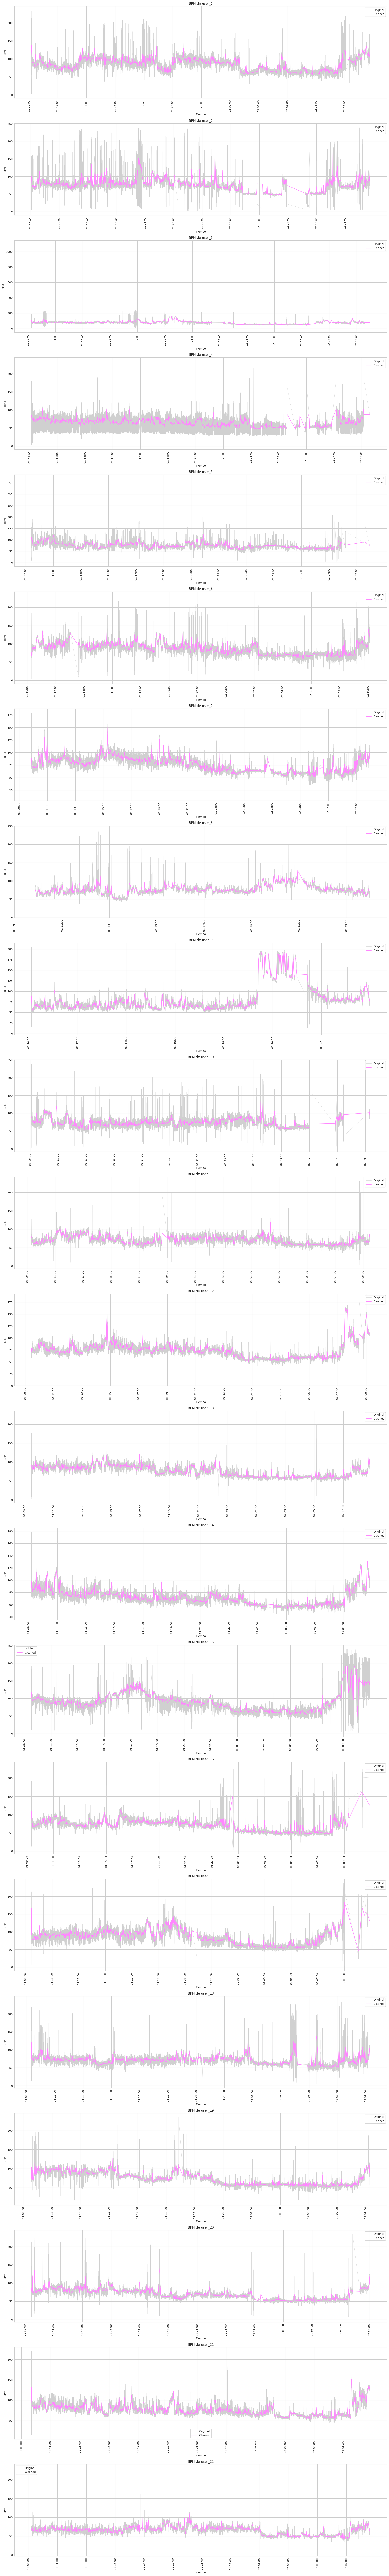

In [17]:
def ax_per_user(df_user, df_clean_user, ax):
    """
    Grafica los BPM de un usuario antes y después del proceso de limpieza.

    Parámetros:
    df_user (pd.DataFrame): DataFrame que contiene los datos del usuario con las columnas 'User', 'datetime' y 'BPM'.
    df_clean_user (pd.DataFrame): DataFrame que contiene los datos limpios del usuario con las columnas 'User', 'Time' y 'BPM_mean'.
    ax (matplotlib.axes._axes.Axes): Ejes de la figura donde se graficarán los datos.

    Retorna:
    ax: Ejes de la figura con los datos graficados.
    """

    # Calculamos el valor medio de BPM para cada marca temporal del df original
    if df_user['datetime'].nunique() > 1:
        df_user_mean = df_user.groupby('datetime')['BPM'].mean().reset_index()
        df_user_mean.rename(columns={'BPM': 'BPM_computed'}, inplace=True)
        df_user_mean['User'] = df_user['User'].values[0]
    else:
        df_user_mean = df_user[['datetime', 'BPM']].rename(columns={'BPM': 'BPM_computed'})
        df_user_mean['User'] = df_user['User'].values[0]

    # Redondeamos los valores de BPM_computed
    df_user_mean['BPM_computed'] = round(df_user_mean['BPM_computed'], 2)

    ####### PLOT #######
    # Configuramos el estilo de los gráficos
    sns.set_style(style='whitegrid')

    sns.lineplot(data=df_user_mean, x='datetime', y='BPM_computed', color='#D0D0D0', lw=0.5, label='Original', ax=ax)
    sns.lineplot(data=df_clean_user, x='Time', y='BPM_mean', color='#FF87FF', lw=1.5, label='Cleaned', ax=ax)
    ax.set_title(f'BPM de {df_user["User"].values[0]}')
    ax.set_xlabel('Tiempo')
    ax.set_ylabel('BPM')

    # Configuramos los ticks del eje x
    x_ticks = pd.date_range(start=df_user_mean['datetime'].min().replace(minute=0, second=0), 
                            end=df_user_mean['datetime'].max(), freq='2h')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([tick.strftime('%d %H:%M') for tick in x_ticks], rotation=90)

    return ax


# Obtenemos la lista de usuarios
users = df_RR['User'].unique()

# Creamos la figura y los ejes
fig, axes = plt.subplots(len(users), 1, figsize=(20, 6 * len(users)), sharex=False)

# Iteramos sobre los usuarios y los ejes
for user, ax in zip(users, axes):
    df_user = df_RR[df_RR['User'] == user].copy()
    df_user_clean = df_RR_clean[df_RR_clean['User'] == user].copy()
    ax_per_user(df_user, df_user_clean, ax)

plt.tight_layout()
plt.show()

Al visualizar los datos originales y los limpios juntos se descubren muchas cosas interesantes. Por un lado, observamos que hay algunos usuarios con un parón en la toma de datos, como es el caso de los usuarios 16, 17, 18 o 20. La mayoría de estos parones se producen pocas horas antes de terminar el registro. También descubrimos que la presencia de valores altos de frecuencia cardíaca suele darse en periodos de actividad, aunque algunos usuarios presentan valores altos en periodos en los que estos deberían estar durmiendo. Estos datos se cotejarán posteriormente con datos de movimiento y con datos de sueño, permitiéndonos comparar la frecuencia cardíaca, el movimiento y el sueño de los usuarios. Otra cosa a notar es las oscilaciones que se producen en periodos cortos, es decir, en intervalos cortos de tiempo (del orden de minutos) la frecuencia cardíaca suele incrementar y bajar un poco, generando un efecto de dientes de sierra en las series temporales.

Al plotear el histograma de los BPM después de la limpieza, se obtendrá un gráfico más concentrado con menos valores atípicos.

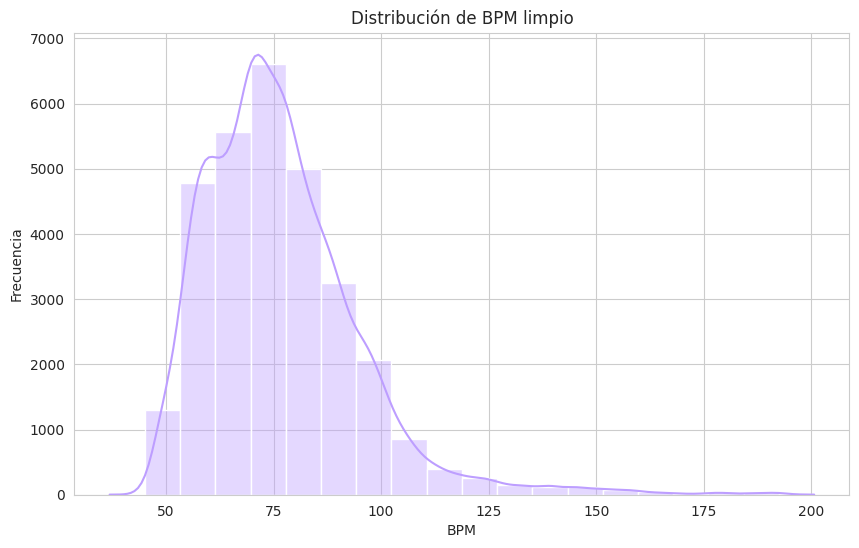

In [18]:
# Configuramos el estilo de los gráficos
sns.set_style(style='whitegrid')

# Creamos para BPM limpio
plt.figure(figsize=(10, 6))
sns.histplot(df_RR_clean['BPM_mean'], bins=20, kde=True, color='#BD9EFF', alpha=0.4)
plt.title('Distribución de BPM limpio')
plt.xlabel('BPM')
plt.ylabel('Frecuencia')
plt.show()

La distribución de BPM (latidos por minuto) de los usuarios muestra una forma asimétrica, con un sesgo hacia la derecha. La mayoría de los valores se concentran entre 50 y 100 BPM, con un pico alrededor de los 75 BPM, lo que probablemente refleja la frecuencia cardíaca en reposo de la mayoría de las personas. Los valores superiores a 100 BPM son menos frecuentes y pueden corresponder a actividad física. La cola a la derecha indica la presencia de valores más altos pero raros, como 150 BPM o más.

A continuación, se ploteará un violin plot para comparar la distribución de BPM de cada usuario.

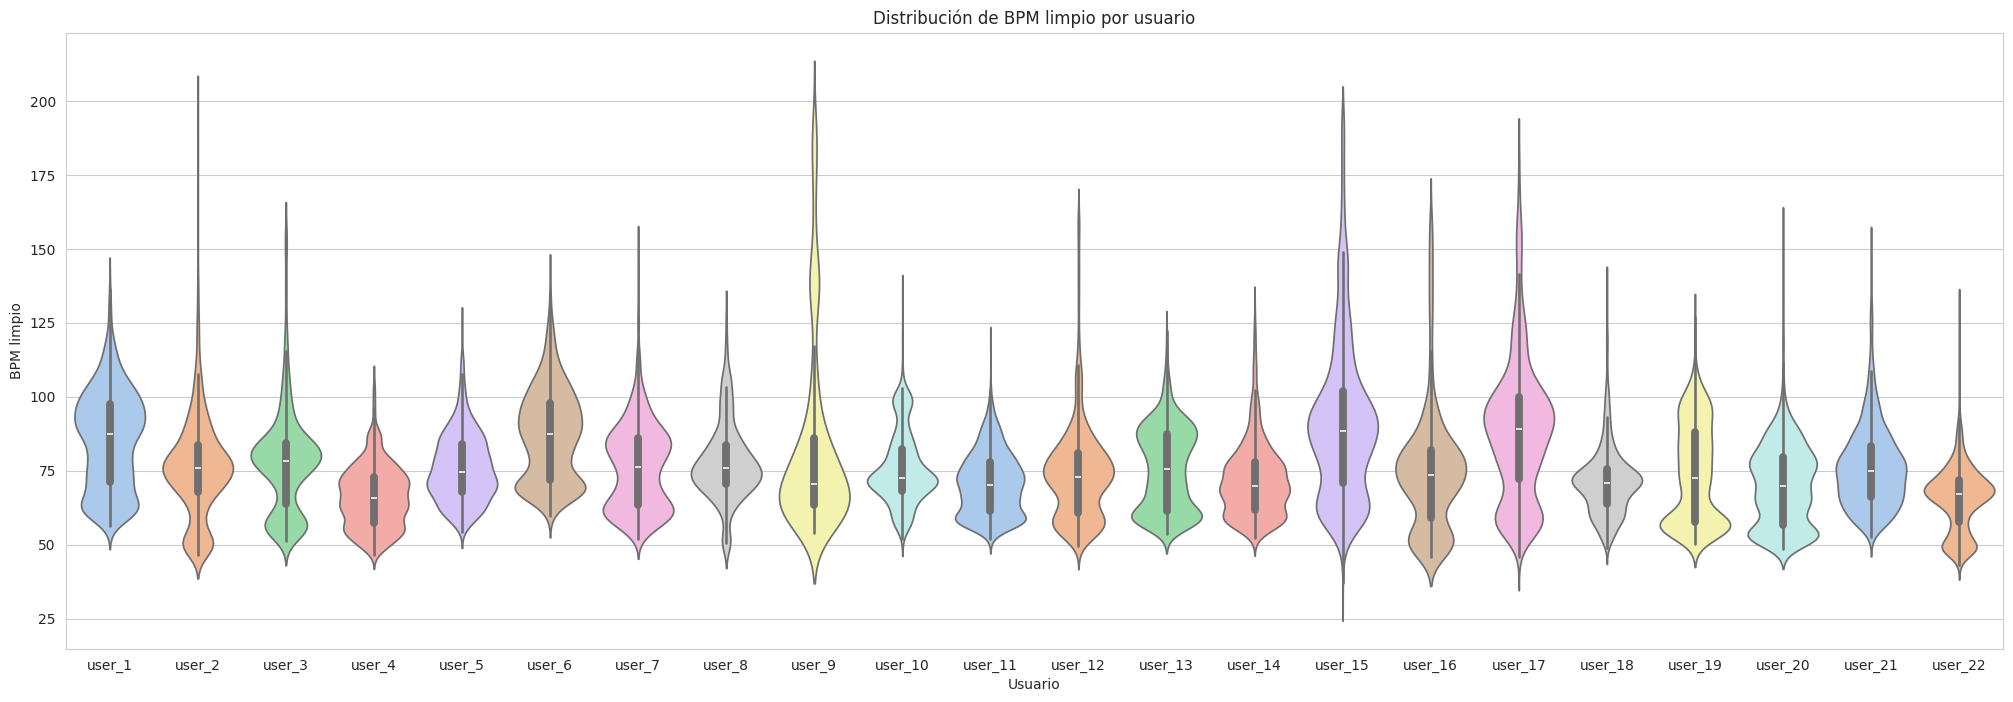

In [19]:
# Configuramos el estilo de los gráficos
sns.set_style(style='whitegrid')

# Se genera un violinplot para cada usuario
plt.figure(figsize=(25, 8))
sns.violinplot(data=df_RR_clean, x='User', y='BPM_mean', inner='box', hue='User', palette='pastel', legend=False)
plt.title('Distribución de BPM limpio por usuario')
plt.xlabel('Usuario')
plt.ylabel('BPM limpio')

plt.show()

En general, la mayoría de los usuarios tienen una mediana de BPM alrededor de 75, con distribuciones que suelen ser simétricas o ligeramente sesgadas hacia valores más altos. Algunos usuarios (como el user_9 y el user_15) tienen distribuciones más amplias, con valores extremos que alcanzan más de 200 BPM, lo que podría indicar episodios de alta activida. En contraste, otros usuarios como el user_4 o el user_12 tienen distribuciones más compactas, lo que sugiere menor variabilidad en sus BPM. Curiosamente los usuarios que presentan valores más altos son los que presentan también valores más bajos. Esta variabilidad podría ser un indicativo de que aquellos que hacen actividad física (BPM mayores) son los mismos que registran una menor frecuencia en reposo. Aunque esta hipótesis no está demostrada y puede deberse a problemas en los sensores o a comportamientos de alta frecuencia cardíaca que no estén relacionados con la actividad física.

# 2. Guardamos el dataframe como un fichero pickle

In [20]:
# Se establece el nombre del archivo 
out_folder = os.path.join('..', '0_data', "clean_MMASH")
filename = 'RR_clean.pkl'

# Comprobamos si la carpeta existe, si no la creamos
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

# Comprobamos si el archivo existe, de ser así lo eliminamos
if os.path.exists(os.path.join(out_folder, filename)):
    os.remove(os.path.join(out_folder, filename))

# Guardamos el df en un archivo pickle
df_RR_clean.to_pickle(os.path.join(out_folder, filename))


# Bibliografía

[1] E4 data - IBI expected signal – empatica support. (n.d.). https://support.empatica.com/hc/en-us/articles/360030058011-E4-data-IBI-expected-signal 
[2] Harvard Health Publishing. (2020, August 30). What your heart rate is telling you - Harvard Health. Harvard Health; Harvard Health. https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you
